# Forman-Ricci curvature

## For undirected unweighted graphs

For a given edge $l_m$ in a graph, the Forman-Ricci curvature is defined as:

$$
F(l_m) = 4 - D_m
$$


Where $D_m$ is the sum of degree between the two nodes

In [163]:
import jax.numpy as jnp
import networkx as nx
import os
import sys
newPath = os.path.dirname(os.path.abspath(""))
if newPath not in sys.path:
    sys.path.append(newPath)
from BI import bi
m = bi(platform='cpu')
adj = m.dist.poisson(4, shape = (10,10), sample = True)
adj = adj.at[jnp.diag_indices(10)].set(0) #set diag to 0
adj_sym = adj + adj.T # sym
adj_bin = adj.at[jnp.where(adj_sym > 0)].set(1)

jax.local_device_count 32


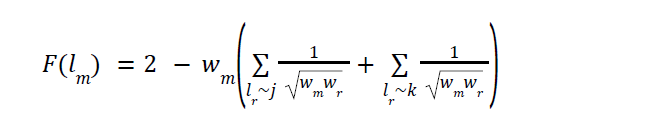

In [ ]:
import jax

@jax.jit
def FRC_single_weigthed(i,edges, degrees, adj, carry ):
    node_i = edges[i, 0]
    node_j = edges[i, 1]
    w_m = adj[node_i, node_j]
    # For node i (and similarly for j), subtract the contribution of edge (i,j) itself.
    sum_i = 1/jnp.square(degrees[node_i] * w_m)
    sum_j = 1/jnp.square(degrees[node_j] * w_m)

    # Compute curvature as given in the document.
    curvature = 2 - w_m * (sum_i + sum_j)
    return carry.at[i].set(curvature)

@jax.jit
def loop_FRC_weigthed(edges, degrees, adj, init_carry):
        return jax.lax.fori_loop(0, 
                                edges.shape[0],
                                lambda i, carry: FRC_single_weigthed(i,edges, degrees, adj, carry),
                                init_carry)
def FRC_weigthed(adj, directed = True):
    if directed:
        degrees = jnp.sum(adj, axis=1) + jnp.sum(adj, axis=0)
        edges = jnp.stack(jnp.nonzero(adj), axis=1)  
    else:
        # Nodes degree
        degrees = jnp.sum(adj, axis=1)
        # Only consider each edge once (upper triangle)
        edges = jnp.stack(jnp.nonzero(adj.at[jnp.tril_indices(10, k=0)].set(0)), axis=1)  

    init_carry = jnp.zeros(edges.shape[0])
    curvature = loop_FRC_weigthed(edges, degrees, adj,init_carry)
    edge = jnp.concat([edges, curvature[:, None]], axis = 1)
    return edge

FRC_weigthed(adj) # col 1 = node i, col 2 = node j, col 3 = FRC weigthed

Array([[0.        , 1.        , 1.96387097],
       [0.        , 2.        , 1.97017234],
       [0.        , 3.        , 1.96747753],
       [0.        , 4.        , 1.96848635],
       [0.        , 5.        , 1.97152529],
       [0.        , 6.        , 1.96894559],
       [0.        , 7.        , 1.97152529],
       [0.        , 8.        , 1.96894559],
       [0.        , 9.        , 1.96894559],
       [1.        , 0.        , 1.96387097],
       [1.        , 2.        , 1.96630137],
       [1.        , 3.        , 1.96360656],
       [1.        , 4.        , 1.96461538],
       [1.        , 5.        , 1.96765432],
       [1.        , 6.        , 1.96507463],
       [1.        , 7.        , 1.96765432],
       [1.        , 8.        , 1.96507463],
       [1.        , 9.        , 1.96507463],
       [2.        , 0.        , 1.97017234],
       [2.        , 1.        , 1.96630137],
       [2.        , 3.        , 1.96990793],
       [2.        , 4.        , 1.97091675],
       [2.

In [ ]:
def FRC_single_unweigthed(network, i, j, weigthed = True):
    if weigthed:
        pass
    else:
        degree_i = jnp.sum(network[i])
        degree_j = jnp.sum(network[j])
        return 4 - (degree_i + degree_j)

FRC_single_unweigthed(adj, 0, 1)

3


Array(-3, dtype=int64)